In [1]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from __future__ import absolute_import, division, print_function, unicode_literals
from numpy import array
from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


sns.set(rc={'figure.figsize':(12,8)})

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/drive/My Drive/data-mortgage/usd.csv')
inq = df.Close
inq = inq.fillna(inq.mean())

In [3]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
'''LSTM and Transfer Learning'''

'LSTM and Transfer Learning'

In [5]:
def preprocessing(series):
    '''
    MinMax Scaling of the raw time series
    Args:
        series: the raw time series
    Returns:
        scaled_series and scaler object
    '''
    
    series = np.array(series)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series.reshape(-1,1))
    scaled_series = scaled.reshape((len(series),))
    
    return scaled_series, scaler

def inverse_transform(series,scaler):
    '''
    Inverse transform of scales series
    Args:
        series: scaled series
        scaler: scaler object
    Returns:
        unscaled series
    '''
    return scaler.inverse_transform(series.reshape(-1,1))

def getSeries(data,p):
    '''
    Splits a given time series proportionally
    for training and testing purposes
    
    Args:
        data: numpy array or pandas series 
              containing the time series.
        p: float value that defines the 
           proportion of the series used
           for training.
    Returns:
        series: time series for training
        y_test: time series for testing
        n_test: number of timesteps 
                in the test series
    
    '''
    n = data.shape[0]
    n_train = int(n * p) 
    n_test = n - n_train

    x = np.arange(n)
        
    index_train = x[:n_train]
    index_test = x[n_train:]
    
    series = data[index_train]

    y_test = data[index_test]
    return series, y_test, n_test

def getInputOutput(series, input_size):
    '''
    Transforms the time series into desired 
    shape to be able to pass to the network
    
    Args:
        series: the time series.
        input_size: int that defines the length 
                    of the input sequence to be 
                    fed to the network
    Returns:
        X_train: input dataset
        y_train: output values
        X_test: the last available sequence
    
    '''
    
    series = np.array(series)
    xlen = len(series)
    xrows = xlen - input_size
    
    X_train, y_train = [], []
    
    for i in range(xrows):
        j = i + input_size
        a = series[i:j, np.newaxis]
        X_train.append(a)
        y_train.append(series[j])
    
    X_train,y_train = np.array(X_train), np.array(y_train)
    X_test = series[xrows:].reshape(1,input_size,1)
    
    
    return X_train, y_train, X_test

In [6]:
def build_LSTM(input_size, hidden_units, dropout, learning_rate):
    '''
    Builds the Network with LSTM hidden layers
    
    Args:
        input_size: int that defines the length 
                    of the input sequence to be 
                    fed to the network
        hidden_units: int/list specifying the number 
                      of hidden units in the hidden 
                      layer/layers
        dropout: boolean specifing whether to add dropout
                 with 0.5 rate per layer
        learning_rate: learning rate of the Adam 
                       optimization algorithm
    Returns:
        model: keras sequential model
        
    '''
    h = hidden_units
    

    model = Sequential()
    
    if isinstance(h,list):
    
        model.add(LSTM(h[0], 
                   batch_input_shape=(1,input_size, 1), 
                   return_sequences=True, 
                   stateful=True))
                  
        if dropout:
            model.add(Dropout(rate=0.5))

        if len(h) > 2:
            #removing 1st and last units
            for index, units in enumerate(h[1:-1]):  
                model.add(LSTM(units, 
                               batch_input_shape=(1,h[index], 1), 
                               return_sequences=True, 
                               stateful=True)) 
                if dropout:
                    model.add(Dropout(rate=0.5))

        model.add(LSTM(h[-1], 
                       batch_input_shape=(1,h[-2], 1), 
                       return_sequences=False, 
                       stateful=True))
        if dropout:
            model.add(Dropout(rate=0.5))
    else:
        model.add(LSTM(h, 
                   batch_input_shape=(1,input_size, 1), 
                   return_sequences=False, 
                   stateful=True)) 
        if dropout:
            model.add(Dropout(rate=0.5))
        
    
    model.add(Dense(1))
    adam = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=adam)
    return model

def predict_ahead(model,X_test,n_ahead):
    '''
    Makes predictions based on the last available sequence
    
    Args:
        model: keras sequential model
        X_test: the last available sequence
        n_ahead: number of predictions to make 
        
    Returns:
        predictions: numpy array containing the predicted values
        
    '''    
    predictions = np.zeros(n_ahead)
    predictions[0] = model.predict(X_test,batch_size = 1) ###############################
    
    if n_ahead > 1:
        for i in range(1, n_ahead):
            x_new = np.append(X_test[0][1:],predictions[i-1])
            X_test = x_new.reshape(1,x_new.shape[0],1)
            predictions[i] = model.predict(X_test,batch_size = 1) #######################
    return predictions

def FitForecast(X_train, y_train, X_test, n_ahead, input_size,
                hidden_units, dropout, val_split, learning_rate, 
                epochs, trained_model):
    
    '''
    Fits a model and returns the predicted values. 
    Optionally weights from another network can be passed 
    
    Args:
        X_train: input dataset for training
        y_train: output dataset for training
        X_test: the last available sequence
        n_ahead: number of predictions to make 
        time_series: the time series of interest
        input_size: int that defines the length 
                    of the input sequence to be 
                    fed to the network
        hidden_units: int/list specifying the number 
                      of hidden units in the hidden 
                      layer/layers
        dropout: boolean specifing whether to add dropout
                 with 0.5 rate per layer
        learning_rate: learning rate of the Adam 
                       optimization algorithm
        epochs: int that defines the number of 
                training phases through the
                training dataset
        trained_model: already trained keras sequential 
                       model
        
    Returns:
        model: keras sequential model
        predictions: numpy array containing the predicted values
        history: training and validation loss history
        
    '''
    model = build_LSTM(input_size,hidden_units,dropout, learning_rate)
    
    if trained_model is not None:
        model.set_weights(weights = trained_model.get_weights())        
    
    
    history = model.fit(x=X_train, y=y_train, 
                batch_size=1, epochs=epochs, 
                verbose=1, validation_split=val_split,
                shuffle=False)

    predictions = predict_ahead(model,X_test,n_ahead)
    return model, predictions, history

def FitEvaluate(time_series,params):
    '''
    Calls the pipeline to fit an LSTM model to the 
    given time series
    
    Args:
        time_series: the time series of interest
        params: a dictionary specifying parameters
                {input_size, hidden_units, dropout,
                learning_rate, n_ahead, val_split, 
                epochs, verbose, plot}
    Returns:
        model: keras sequential model      
        mse: mean squared error of the prediction
        history: training and validation loss history
        
    '''   
    
    for k in params.keys():
        globals()[k] = params[k]
    
    
    scaled_series, scaler = preprocessing(time_series)
    series, y_test, n_test = getSeries(scaled_series,0.7)
    X_train,y_train,X_test = getInputOutput(series,input_size+1) ## added +1
    
    # show only n_ahead number of actual values
    y_test = y_test[np.arange(n_ahead)]

    new_model, predictions, history = FitForecast(X_train,y_train,X_test,n_ahead,
                                        input_size,hidden_units,dropout, val_split,
                                        learning_rate,epochs,trained_model=None)
    
    # rescaling
    series = inverse_transform(series, scaler)
    y_test = inverse_transform(y_test, scaler)
    predictions = inverse_transform(predictions, scaler)
    
    mse = mean_squared_error(y_true=y_test,y_pred=predictions)
    
    if verbose:
        print('\n')
        print('======== Prediction Evaluation =========')
        print('MSE is {}'.format(round(mse,4)))
        
    if plot:
        ViewLoss(history)
        view_predictions(series,predictions,y_test,'Actual vs Forecast')
    return new_model, mse, history

def TransferLearning(time_series,params,model):
    '''
    Calls the pipeline to fit an LSTM model to the 
    given time series with and without knowledge
    transfer
    
    Args:
        time_series: the time series of interest
        params: a dictionary specifying parameters
                {input_size, hidden_units, dropout,
                learning_rate, n_ahead, val_split, 
                epochs, verbose, plot}
        model: already trained keras sequential 
               model
    Returns:
        mean squared errors of the predictions
        and 2 plots         
    '''
    for k in params.keys():
        globals()[k] = params[k]
    
    val_split = 0
    
    scaled_series, scaler = preprocessing(time_series)
    series, y_test, n_test = getSeries(scaled_series,0.7)
    X_train,y_train,X_test = getInputOutput(series,input_size)

    # show only n_ahead number of actual values
    y_test = y_test[np.arange(n_ahead)]

    
    print('*** Fitting a model without knowledge transfer ***')
    model_noTransfer, predictions_noTransfer, _ = FitForecast(X_train,y_train,
                                                             X_test,n_ahead,
                                               input_size,hidden_units,
                                                             dropout,val_split,
                                                             learning_rate,
                                               epochs,
                                                             trained_model=None)
    
    print('\n')
    print('*** Fitting a model with knowledge transfer ***')
    model_withTransfer, predictions_withTransfer, _ = FitForecast(X_train,y_train,
                                                                 X_test,n_ahead,
                                                                 input_size,hidden_units,
                                                                 dropout,val_split,
                                                                 learning_rate,
                                                                 epochs,
                                                                 trained_model=model)
    
    # rescaling
    series = inverse_transform(series, scaler)
    y_test = inverse_transform(y_test, scaler)
    predictions_noTransfer = inverse_transform(predictions_noTransfer, scaler)
    predictions_withTransfer = inverse_transform(predictions_withTransfer, scaler)
    
    mse_noTransfer = mean_squared_error(y_true=y_test,y_pred=predictions_noTransfer)
    mse_withTransfer = mean_squared_error(y_true=y_test,y_pred=predictions_withTransfer)
      
    print('\n')
    print('======== Results for no knowledge transfer =========')
    print('The RMSE is {}'.format(round(np.sqrt(mse_noTransfer),4)))
    print('\n')
    print('======== Results for knowledge transfer =========')
    print('The RMSE is {}'.format(round(np.sqrt(mse_withTransfer),4)))
        
    view_predictions(series,predictions_noTransfer,y_test,title='LSTM')
    view_predictions(series,predictions_withTransfer,y_test,title='Transfer Learning')

    return predictions_noTransfer, predictions_withTransfer

def GridSearch(series,params_grid):
    '''
    Runs a grid search over specified parameter ranges
    Args: 
        series: the time series of interest
        params_grid: a dictionary specifying parameters
                    {input_size, hidden_units, dropout,
                    learning_rate, n_ahead, val_split, 
                    epochs, verbose, plot} and their 
                    possible value ranges
    Returns:
        model: the model with the lowest MSE 
        logs: logs of all combinations        
       
    '''
    param_names = list(params_grid.keys())
    param_values = list(params_grid.values()) 
    combinations = list(itertools.product(*param_values))
    
    logs = pd.DataFrame(combinations,columns=param_names)
    
    mse_prev = 1
    for index, comb in enumerate(combinations):
        
        print('Fitting {}/{} model'.format(index+1,len(combinations)))
        params = dict(zip(param_names,comb))
        model, mse, history = FitEvaluate(series,params)
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        
        if mse < mse_prev:
            mse_prev = mse
            best_model = model
        
        logs.at[index,'mse'] = mse
        logs.at[index,'mean_training_loss'] = np.mean(train_loss)
        logs.at[index,'std_training_loss'] = np.std(train_loss)
        logs.at[index,'mean_val_loss'] = np.mean(val_loss)
        logs.at[index,'std_val_loss'] = np.std(val_loss)
    logs.to_csv('results.csv',index=False)
    # view_predictions(series,best_predictions,y_test,'Actual vs Forecast')
    return best_model, logs

def generalTuning(series1, series2, params):
    
    '''
    Fitting 3 models trained on 
    {general domain,general+in-domain,in-domain only}
    and comparing them
    Args: 
        series1: target related time series 
        series2: target time series
        params: a dictionary specifying parameters
                {input_size, hidden_units, dropout,
                learning_rate, n_ahead, val_split, 
                epochs, verbose, plot}
    Returns:
        mean squared errors of the predictions
        and 3 plots 
    
    '''
    
    time_series = np.concatenate([series1,series2])
        
    
    
    for k in params.keys():
        globals()[k] = params[k]
        
    val_split = 0
    
    # preprocessing general series
    scaled_general, scaler_general = preprocessing(time_series)
    series_general, _, __ = getSeries(scaled_general,0.9)
    X_train_general,y_train_general,___ = getInputOutput(series_general,input_size)

    # preprocessing the target series
    scaled_target, scaler_target = preprocessing(series2) 
    series_target, y_test_target, n_test = getSeries(scaled_target,0.7)
    X_train_target,y_train_target,X_test_target = getInputOutput(series_target,input_size)

    # comparing predictions with only n_ahead number of actual values
    y_test_target = y_test_target[np.arange(n_ahead)]

    
    # build and train a model on the general domain (time_series)
    
    print('*** Fitting a model on general domain ***')

    
    model_general, predictions_pre_tuned, hist = FitForecast(X_train_general,y_train_general,
                                                             X_test_target,n_ahead,
                                                             input_size, hidden_units,
                                                             dropout, val_split,
                                                             learning_rate,
                                                             epochs,
                                                             trained_model=None)                                               
                                                             
                                                             
                                                        
 
    # initiallize a model for target
    model_tuned = build_LSTM(input_size, hidden_units, dropout, learning_rate)
        
    # transfer the knowledge from the pre-trained model
    # and tune it only on the target domain (series2)
    model_tuned.set_weights(weights=model_general.get_weights())        
    
    
    print('\n *** Tuning a model on target domain ***')

    model_tuned.fit(x=X_train_target, y=y_train_target, 
                        batch_size=1, epochs=epochs, 
                        verbose=1, validation_data=None,
                        shuffle=False)
    
    predictions_tuned = predict_ahead(model_tuned,X_test_target,n_ahead)
    
    
   
    print('\n *** Fitting a model on target domain only ***')

    model_target, predictions_target,hist2 = FitForecast(X_train_target,y_train_target,
                                                   X_test_target,n_ahead,
                                                   input_size, hidden_units,
                                                   dropout, val_split,
                                                   learning_rate,
                                                   2 * epochs,
                                                   trained_model=None)                                               


    series_target = inverse_transform(series_target,scaler_target)
    y_test_target = inverse_transform(y_test_target,scaler_target)
    
    series_general = inverse_transform(series_general,scaler_general)
    predictions_pre_tuned = inverse_transform(predictions_pre_tuned,scaler_target)
    mse_pre_tuned = mean_squared_error(y_true=y_test_target,y_pred=predictions_pre_tuned)
    
    predictions_tuned = inverse_transform(predictions_tuned,scaler_target)
    mse_tuned = mean_squared_error(y_true=y_test_target,y_pred=predictions_tuned)
    
    predictions_target = inverse_transform(predictions_target,scaler_target)  
    mse_target = mean_squared_error(y_true=y_test_target,y_pred=predictions_target)
    
    print('\n')
    print('======== Results for pre_tuned model =========')
    print('The RMSE is {}'.format(round(np.sqrt(mse_pre_tuned),4)))
    print('\n')
    print('======== Results for tuned model =========')
    print('The RMSE is {}'.format(round(np.sqrt(mse_tuned),4)))
    
    print('\n')
    print('======== Results for target model only =========')
    print('The RMSE is {}'.format(round(np.sqrt(mse_target),4)))
    
        
    view_predictions([series_general,series_target],predictions_pre_tuned,y_test_target,title='Pre-tuned')
    view_predictions([series_general,series_target],predictions_tuned,y_test_target,title='Tuned')
    view_predictions(series_target,predictions_target,y_test_target,title='Target only')


In [7]:
def ACF(series,lags):
    '''
    Plots the Autocorrelation graph
    of the series
    Args:
        series: time series of interest
        lags: int specifying number of 
              periods to look back
    Returns: plot
    '''
    # plot_acf(series, lags=lags)
    # plt.savefig('ACF.png')
    # plt.show()

def plotSeries(series_dict):
    '''
    Plots several time series
    Args:
        series_dict: dict with series names as keys
                     and time series as values
    Returns:
        plot
        
    '''
    n_series = len(series_dict) - 1
    names = list(series_dict.keys())
    
    plt.figure(figsize=(10,20))
    
    for i in range(n_series):
        plt.subplot(n_series,1,i+1)
        plt.title(names[i+1])
        plt.plot(series_dict['t'],series_dict[names[i+1]])
        
    plt.show()

In [8]:
def ViewLoss(history):
    '''
    Plots the history of model training
    '''
    # plt.plot(history.history['loss'],label='Train')
    # plt.plot(history.history['val_loss'],label='Val')
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend()
    # plt.savefig('loss-history.png')
    # plt.show()

def MAPE(y_true, y_model):
        y_true, y_model = np.array(y_true), np.array(y_model)
        return np.mean(np.abs((y_true - y_model) / y_true)) * 100

def view_predictions(series,predictions,actual,title):
    '''
    Plots the results of the predictions made by the model
    
    Args:
        series: the time series used for training the network
        predictions: numpy array containing the predicted values
        actual: the actual time series not seen by the network
        title: the title of the plot
        
    Returns:
        plot        
        
    '''  
    
    plt.figure(figsize=(8,4))
    plt.title(title)


    if isinstance(series,list):
      tr = series[0].append(actual[0])

      test_index = len(series[0]) + np.arange(len(actual))

      plt.plot(tr, label = 'general')
    else:
      tr = np.append(series, actual[0])

      test_index = len(series) + np.arange(len(actual))
      plt.plot(tr,label = 'Train')

    if len(predictions) > 4:
        plt.plot(test_index, predictions,label = f'Predicted MAPE = {round(MAPE(actual, predictions), 2)} %',color='g')
        plt.plot(test_index, actual,label = 'Test',color='orange')

    else:
        plt.scatter(test_index, predictions,label = f'Predicted MAPE = {round(MAPE(actual, predictions), 2)} %',color='g')
        plt.scatter(test_index, actual,label = 'Test',color='orange') 
    
    # plt.xlabel('Date')
    # plt.ylabel('Million rubles')
    
    # plt.legend(loc='upper left')
    plt.show()

In [9]:
# params_grid = {'input_size': [3,5,20],
#               'hidden_units':[100,[100,50],[100,50,50], [50,50]],
#               'dropout': [True, False],
#               'learning_rate':[4e-5],
#               'n_ahead':[12],
#               'val_split': [0.3],
#               'epochs':[20],
#               'verbose':[False, True],
#               'plot':[False]}

# model, logs = GridSearch(inq,params_grid)

In [10]:
targ = pd.read_csv('/content/drive/My Drive/data-mortgage/cb_jan.csv')
targ = targ.Money

In [11]:
'''
BEST PARAMETERS FOR CB DATA and euro

params = {'input_size': 25,
          'hidden_units':[50,50],
          'dropout': False,
          'learning_rate':4e-5,
          'n_ahead':12,
          'val_split': 0.3,
          'epochs':20,
          'verbose': True,
          'plot': True}

params = {'input_size': 10,
          'hidden_units':[50,50],
          'dropout': False,
          'learning_rate':4e-5,
          'n_ahead':9,
          'val_split': 0.3,
          'epochs':20,
          'verbose': True,
          'plot': True}
          
          '''

params = {'input_size': 21,
          'hidden_units':[1000, 1000],
          'dropout': False,
          'learning_rate':4e-5,
          'n_ahead':10,
          'val_split': 0.3,
          'epochs':20,
          'verbose': True,
          'plot': True}

Epoch 1/20
400/400 [==============================] - 20s 42ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 2/20
400/400 [==============================] - 16s 39ms/step - loss: 0.0019 - val_loss: 6.6866e-04
Epoch 3/20
400/400 [==============================] - 15s 39ms/step - loss: 0.0019 - val_loss: 7.0792e-04
Epoch 4/20
400/400 [==============================] - 15s 39ms/step - loss: 0.0020 - val_loss: 7.3475e-04
Epoch 5/20
400/400 [==============================] - 15s 39ms/step - loss: 0.0020 - val_loss: 7.2266e-04
Epoch 6/20
400/400 [==============================] - 15s 39ms/step - loss: 0.0020 - val_loss: 6.8941e-04
Epoch 7/20
400/400 [==============================] - 15s 39ms/step - loss: 0.0019 - val_loss: 6.3494e-04
Epoch 8/20
400/400 [==============================] - 15s 39ms/step - loss: 0.0018 - val_loss: 5.7613e-04
Epoch 9/20
400/400 [==============================] - 15s 39ms/step - loss: 0.0017 - val_loss: 5.0918e-04
Epoch 10/20
400/400 [=============================

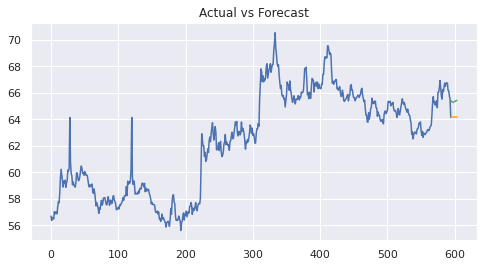

In [12]:
model, mse, hist = FitEvaluate(inq,params)

*** Fitting a model without knowledge transfer ***
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.0909
Epoch 2/20
1/1 [==============================] - 0s 43ms/step - loss: 0.0823
Epoch 3/20
1/1 [==============================] - 0s 43ms/step - loss: 0.0739
Epoch 4/20
1/1 [==============================] - 0s 43ms/step - loss: 0.0658
Epoch 5/20
1/1 [==============================] - 0s 43ms/step - loss: 0.0577
Epoch 6/20
1/1 [==============================] - 0s 41ms/step - loss: 0.0497
Epoch 7/20
1/1 [==============================] - 0s 39ms/step - loss: 0.0416
Epoch 8/20
1/1 [==============================] - 0s 41ms/step - loss: 0.0335
Epoch 9/20
1/1 [==============================] - 0s 40ms/step - loss: 0.0254
Epoch 10/20
1/1 [==============================] - 0s 40ms/step - loss: 0.0176
Epoch 11/20
1/1 [==============================] - 0s 37ms/step - loss: 0.0104
Epoch 12/20
1/1 [==============================] - 0s 39ms/step - loss: 0.0044
Epoch 13/20


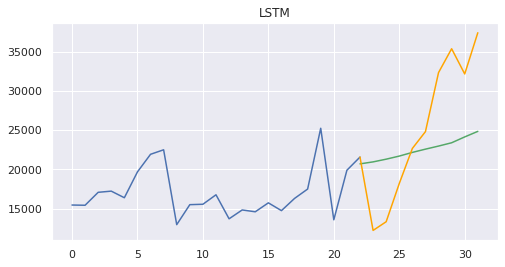

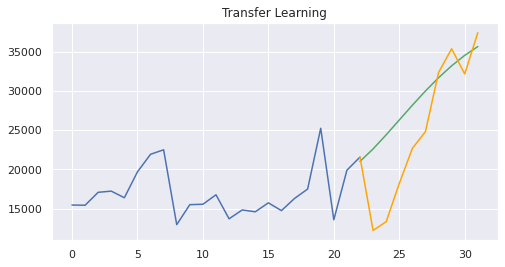

In [13]:
noTransf, withTransf = TransferLearning(targ,params,model=model)

In [14]:
targ = pd.read_csv('/content/drive/My Drive/data-mortgage/cb_jan.csv', index_col='Date')
train = targ[:int(len(targ)*0.7)]
test = targ[len(train):]
predictions_noTrans = pd.DataFrame(data={'noTransf':noTransf.ravel()})
predictions_noTrans = predictions_noTrans.set_index(pd.DatetimeIndex(test.index))
predictions_withTrans = pd.DataFrame(data={'withTransf':withTransf.ravel()})
predictions_withTrans = predictions_withTrans.set_index(pd.DatetimeIndex(test.index))

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape1 = round(MAPE(test, predictions_withTrans), 2)
mape2 = round(MAPE(test, predictions_noTrans), 2)

In [15]:
'''ARIMA and BASELINE'''

'ARIMA and BASELINE'

In [16]:
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

# let's load data...
df = pd.read_csv('/content/drive/My Drive/data-mortgage/cb_jan.csv',',', index_col=['Date'], parse_dates=['Date'], dayfirst=True, encoding='cp1251')

In [17]:
train = df[:int(len(df)*0.7)]
test = df[int(len(df)*0.7):]
X = train.Money
result = adfuller(X)
# 'ADF Statistic result[0]
# 'p-value result[1]
if  result[1] > 0.05:
  d = 1
else:
  d = 0

In [18]:
model = sm.tsa.ARIMA(train, (0, d, 2)).fit(disp=False)
lst_train = []
for i in train.Money:
    lst_train.append(i)
predict_s = model.predict('2020-04-01', '2021-01-01', dynamic=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [19]:
# Baseline 

from pandas import DataFrame, concat

# Create lagged dataset
values = DataFrame(df.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.7)
train, testt = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = testt[:,0], testt[:,1]

In [20]:
def model_persistence(x):
    return x

from sklearn.metrics import mean_squared_error

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
predictions = pd.DataFrame(data={'baseline':predictions})
predictions = predictions.set_index(pd.DatetimeIndex(test.index))

In [21]:
predict_s_new_point = [df.Money[len(train)]]
for i in range(len(predict_s)):
  predict_s_new_point.append(predict_s.values[i])

predict_s_new_point = pd.DataFrame({'ARIMA': predict_s_new_point})
predict_s_new_point = predict_s_new_point.set_index(df.Money[len(train):].index)

predictions_new_point = [df.Money[len(train)]]
for i in range(len(predictions)):
  predictions_new_point.append(predictions.values[i])

predictions_new_point = pd.DataFrame({'Baseline': predictions_new_point})
predictions_new_point = predictions_new_point.set_index(df.Money[len(train):].index)

predictions_noTrans_new_point = [df.Money[len(train)]]
for i in range(len(predictions_noTrans)):
  predictions_noTrans_new_point.append(predictions_noTrans.values[i])

predictions_noTrans_new_point = pd.DataFrame({'LSTM': predictions_noTrans_new_point})
predictions_noTrans_new_point = predictions_noTrans_new_point.set_index(df.Money[len(train):].index)

predictions_withTrans_new_point = [df.Money[len(train)]]
for i in range(len(predictions_withTrans)):
  predictions_withTrans_new_point.append(predictions_withTrans.values[i])

predictions_withTrans_new_point = pd.DataFrame({'LSTM': predictions_withTrans_new_point})
predictions_withTrans_new_point = predictions_withTrans_new_point.set_index(df.Money[len(train):].index)

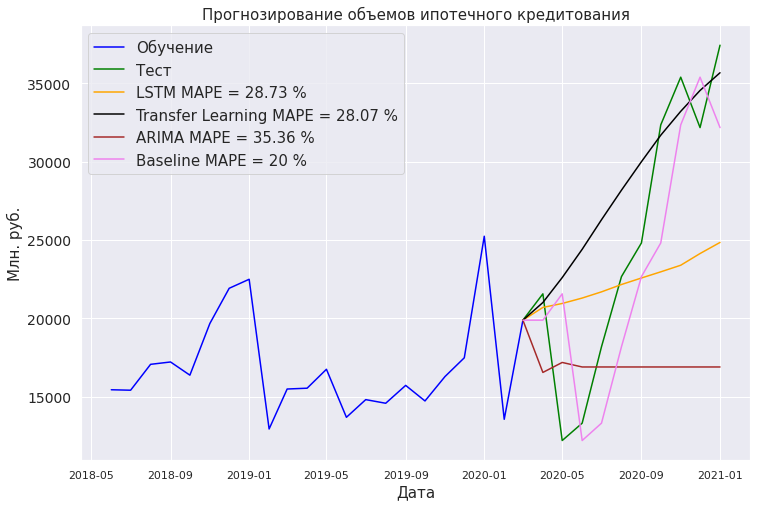

In [22]:
sns.set(rc={'figure.figsize':(12,8)})

plt.plot(df.Money[:len(train)+1], color='blue', label='Обучение')
plt.plot(df[len(train):], color='green', label='Тест')

plt.plot(predictions_noTrans_new_point, color='orange', label=f'LSTM MAPE = {mape2} %')
plt.plot(predictions_withTrans_new_point, color='black', label=f'Transfer Learning MAPE = {mape1} %')


plt.plot(predict_s_new_point, color='brown',  label=f"ARIMA MAPE = {round(MAPE(test, predict_s), 2)} %")
plt.plot(predictions_new_point, color='violet', label=f'Baseline MAPE = {int(MAPE(test.Money, predictions.baseline))} %')

plt.yticks(fontsize=14)

plt.title('Прогнозирование объемов ипотечного кредитования', fontsize=15)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Млн. руб.', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig('predict_rus.png', dpi=300)